###### Inicialização

In [ ]:
!pip install meteostat yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime, date, timedelta
from IPython.display import Markdown
from itertools import product

from math import log
from scipy import stats
from scipy.optimize import minimize
import statsmodels.api as sm
from statsmodels.graphics import tsaplots as tsa

from sklearn import metrics
from sklearn.model_selection import TimeSeriesSplit
 
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (22,6)

from meteostat import Point, Daily, Hourly

from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()

import seaborn as sns
import plotly.graph_objects as go

import warnings
warnings.filterwarnings("ignore")

In [ ]:
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams["figure.figsize"] = (22,6)

In [ ]:
def resultado_adf(resultado, alpha = .05):
  adf, pvalue, usedlag, nobs, critical = resultado[0:5]
  
  display(Markdown('Statistics=%.3f, p-valor=%.8f' % (adf, pvalue)))
  # interpretando resultados
  if pvalue > alpha:
      display(Markdown("**A série não é estacionária (falhamos em rejeitar H0)**"))
  else:
      display(Markdown('**A série é estacionária (rejeitamos H0)**'))

In [ ]:
def resultado_white(resultado, alpha = .05):
  lm, p_value, fvalue, fp_value = resultado[0:5]
  
  display(Markdown('Statistics=%.3f, p-valor=%.8f' % (lm, p_value)))
  # interpretando resultados
  if p_value > alpha:
      display(Markdown("**A série não é heterocedástica (falhamos em rejeitar H0)**"))
  else:
      display(Markdown('**A série é heterocedástica (rejeitamos H0)**'))

In [ ]:
mape = lambda y_true, y_pred: np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Captura dos dados de temperatura

In [ ]:
start = datetime(2012, 1, 1)
end = datetime(2022, 10, 31)

location = Point(-11.0056387, -37.2432436) #Aracaju

aracaju = Daily(location, start, end)
serie_aracaju = aracaju.fetch()

serie_aracaju.tavg.fillna(serie_aracaju.tavg.mean(),inplace=True)

In [ ]:
start = datetime(2018, 1, 1)
end = datetime(2022, 10, 31)

location = Point(-11.0056387, -37.2432436) #Aracaju

aracaju_intra = Hourly(location, start, end)
aracaju_intradiario = aracaju_intra.fetch()

aracaju_intradiario.temp.fillna(aracaju_intradiario.temp.mean(),inplace=True)

# Análise de Séries temporais (Sessão 16)
---
Modelando Séries (parte 7)

## Ajustamento para um horizonte futuro

In [ ]:
def visualizaModelo(series, model, n_steps, teste=None, plot_intervals=False, scale=1.96):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies
    """

    data = series.copy().to_frame()
    data.columns = ["actual"]
    data["model"] = model.fittedvalues[model.fittedvalues.index >= data.index[0]]

    forecast = model.predict(start=data.index[-1], end=data.index[-1] + timedelta(days=n_steps))
    forecast = data.model.append(forecast)

    mae = metrics.mean_absolute_error(series, data["model"])
    deviation = np.std(series - data["model"])
    lower_bond = forecast - (mae + scale * deviation)
    upper_bond = forecast + (mae + scale * deviation)

    plt.figure(figsize=(20, 10))
    plt.plot(forecast, label="Model")
    plt.plot(data.actual, label="Real Treino")
    if teste is not None:
      plt.plot(data.actual, label="Real Teste")
    error = mape(series.values, data["model"])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))

    if plot_intervals:
        plt.plot(upper_bond, "r--", alpha=0.5, label="Up/Low confidence")
        plt.plot(lower_bond, "r--", alpha=0.5)
        plt.fill_between(
            x=upper_bond.index,
            y1=upper_bond,
            y2=lower_bond,
            alpha=0.2,
            color="grey",
        )

    plt.vlines(
        series.iloc[-20:].index[0],
        ymin=min(lower_bond),
        ymax=max(upper_bond),
        linestyles="dashed",
    )

    plt.axvspan(series.iloc[-20:].index[0], forecast.index[-1], alpha=0.3, color="lightgrey")
    plt.grid(True)
    plt.axis("tight")
    plt.legend(loc="best", fontsize=13);

### Ajustando a Suavização Exponencial

In [ ]:
holtwinters_aju = sm.tsa.ExponentialSmoothing(serie_aracaju.tavg, initialization_method='estimated',
                                       trend="add", seasonal="add", seasonal_periods=365).fit(
                                        smoothing_level=.6, smoothing_trend=.2, smoothing_seasonal = .3, optimized=True)

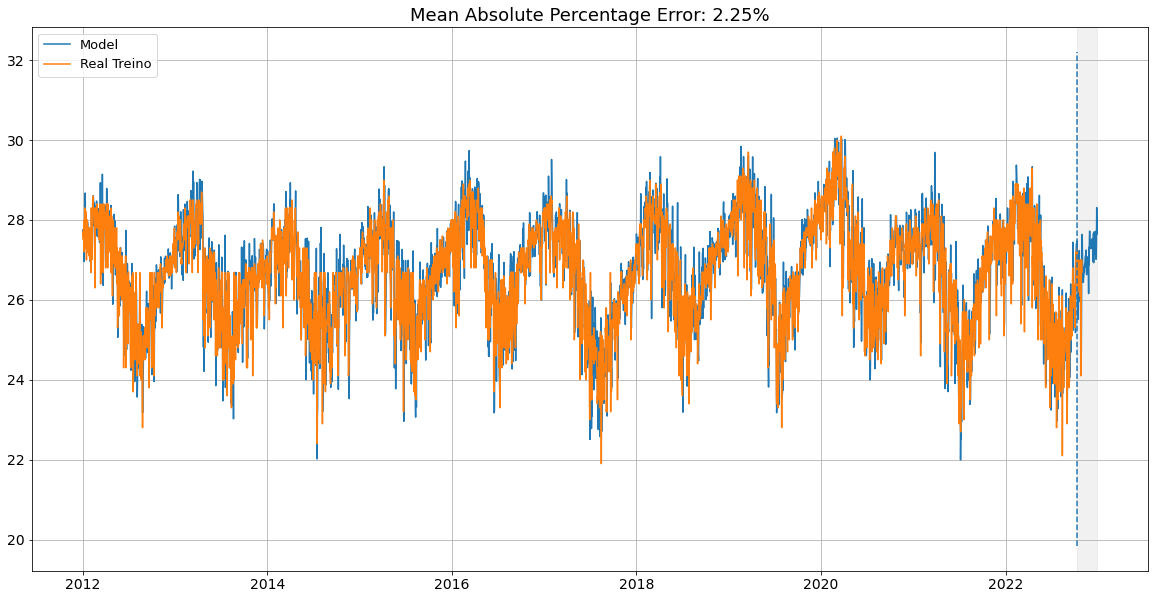

In [ ]:
visualizaModelo(serie_aracaju.tavg, holtwinters_aju, 60)

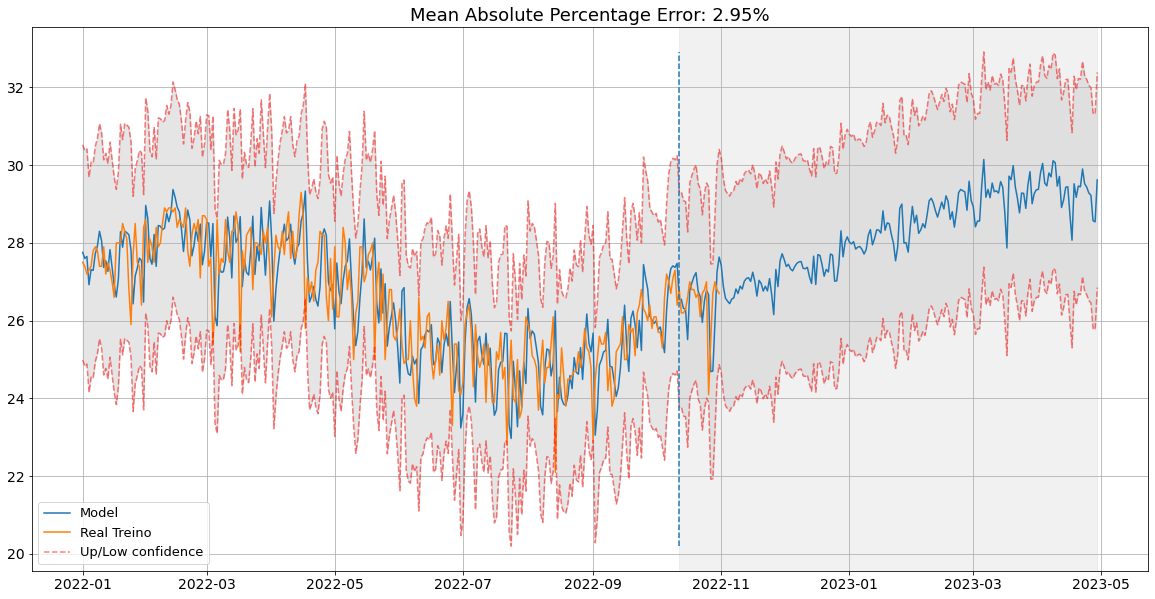

In [ ]:
visualizaModelo(serie_aracaju.tavg[serie_aracaju.index >= '2022-01-01'], holtwinters_aju, 180, plot_intervals=True)

### Ajustando o (S)ARIMA(X)

In [ ]:
modelo_arima = sm.tsa.arima.ARIMA(serie_aracaju.tavg, order=(2, 1, 2)).fit()

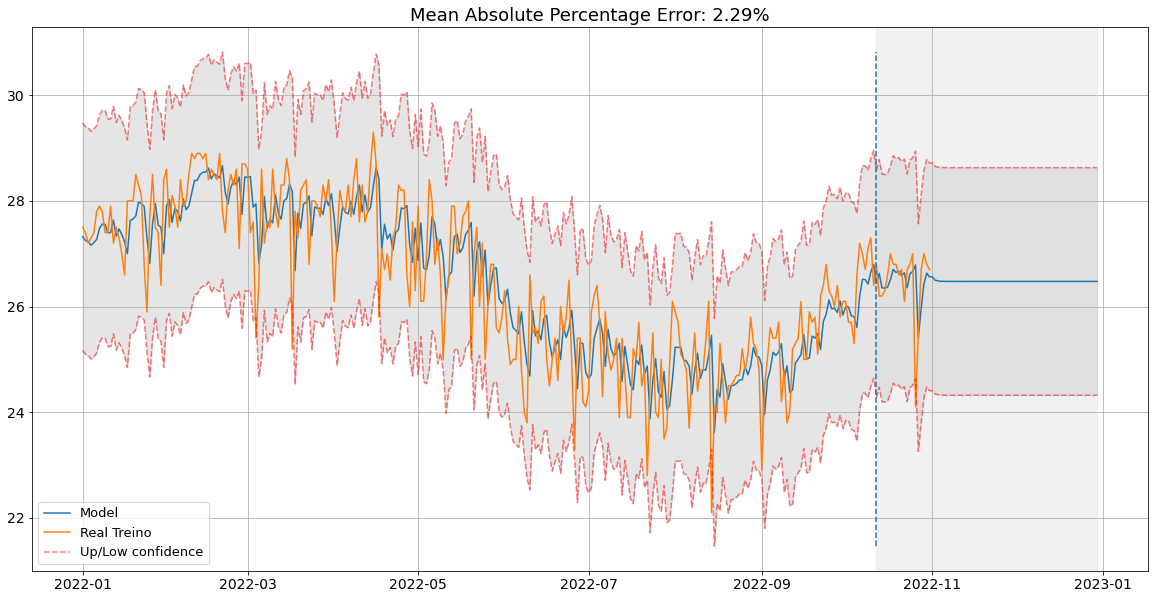

In [ ]:
visualizaModelo(serie_aracaju.tavg[serie_aracaju.index >= '2022-01-01'], modelo_arima, n_steps=60, plot_intervals=True)

## Métricas de Avaliação

### Principais Métricas

- **R Quadrado**: coeficiente de determinação (em econometria, pode ser interpretado como a porcentagem de variância explicada pelo modelo). Varia entre: $(-∞, 1]$.
  - $R^2 = 1 - \frac{SS_{resíduo}}{SS_{total}} = 1 - \frac{\sum^n_{i=1}{(y_i - \hat{y}_i)^2}}{\sum^n_{i=1}{(y_i - \overline{y}_i)^2}}$

- **Erro absoluto médio (Mean Absolute Error)**: esta é uma métrica interpretável porque tem a mesma unidade de medida que a série inicial. Varia entre: $[0, +∞)$.
  - $MAE = \frac{\sum^n_{i=1}{|y_i - \hat{y}_i|}}{n}$

- **Erro absoluto mediano (Median Absolute Error)**: novamente, uma métrica interpretável que é particularmente interessante porque é robusta para outliers. Varia entre: $[0, +∞)$.
  - $MedAE = mediana(|y_1 - \hat{y}_1|, ..., |y_n - \hat{y}_n|)$

- **Erro quadrático médio (Mean Squared Error)**: a métrica mais comumente usada que atribui uma penalidade maior a grandes erros e vice-versa. Varia entre: $[0, +∞)$.
  - $MSE = \frac{\sum^n_{i=1}{(y_i - \hat{y}_i)^2}}{n}$

- **Erro Quadrático médio logarítimico (Mean Squared Logarithmic Error)**: praticamente, é o mesmo que MSE, mas tomamos o logaritmo da série. Como resultado, damos mais peso aos pequenos erros também. Isso geralmente é usado quando os dados têm tendências exponenciais. Varia entre: $[0, +∞)$.
  - $MSLE = \frac{1}{n} \sum^n_{i=1}{(log(1 + y_i) - log(1 + \hat{y}_i))^2}$

- **Erro percentual médio absoluto (Mean Absolute Percentage Error)**: é o mesmo que o MAE, mas é calculado como uma porcentagem, o que é muito conveniente quando você deseja explicar a qualidade do modelo para a administração. Varia entre: $[0, +∞)$.
  - $MAPE = \frac{100}{n} \frac{\sum^n_{i=1}{|y_i - \hat{y}_i|}}{y_i}$

In [ ]:
metrics.r2_score
metrics.mean_absolute_error
metrics.median_absolute_error
metrics.mean_squared_error
metrics.mean_squared_log_error
mape = lambda y_true, y_pred: np.mean(np.abs((y_true - y_pred)) / y_true) * 100

### AIC e BIC




O AIC (Akaike’s Information Criteria) e o BIC (Bayesian Information Criteria) são usados ​​como critérios para a robustez do modelo.

\begin{align}
AIC_k &= n \cdot ln(SSE) + 2(k+1) \\
BIC_k &= n \cdot ln(SSE) + (k+1)ln(n)
\end{align}

onde,
\begin{align}
SSE &= \sum^n_{i=1}{(x_i - \hat{x_i})^2}
\end{align}

Aqui, $SSE$ é a soma quadrada do erro, $n$ é o número de registros e $k$ é o número de variáveis ​​incorporadas ao modelo. Em essência, AIC e BIC penalizam a adição de mais variáveis ​​ao modelo. Ao desenvolver um modelo, o objetivo é minimizar os seus valores.

In [ ]:
aic = lambda n, mse, num_params : n * np.log(mse) + 2 * num_params
bic = lambda n, mse, num_params : n * np.log(mse) + num_params * np.log(n)

## Validação de Modelos

Um modelo aprende quantos padrões puder. Alguns padrões capturam a verdadeira relação entre observações passadas e futuras. Mas o modelo também aprende o ruído inerente no conjunto de treinamento. Padrões casuais que não se generalizam bem em observações futuras.

### Separando o treino do teste

#### Holt-Winters

In [ ]:
split = int(len(serie_aracaju.tavg) * 80 / 100) #encontrando o ponto de separação de 80% para treino e 20% para teste
treino, teste = serie_aracaju.tavg[:split], serie_aracaju.tavg[split:]

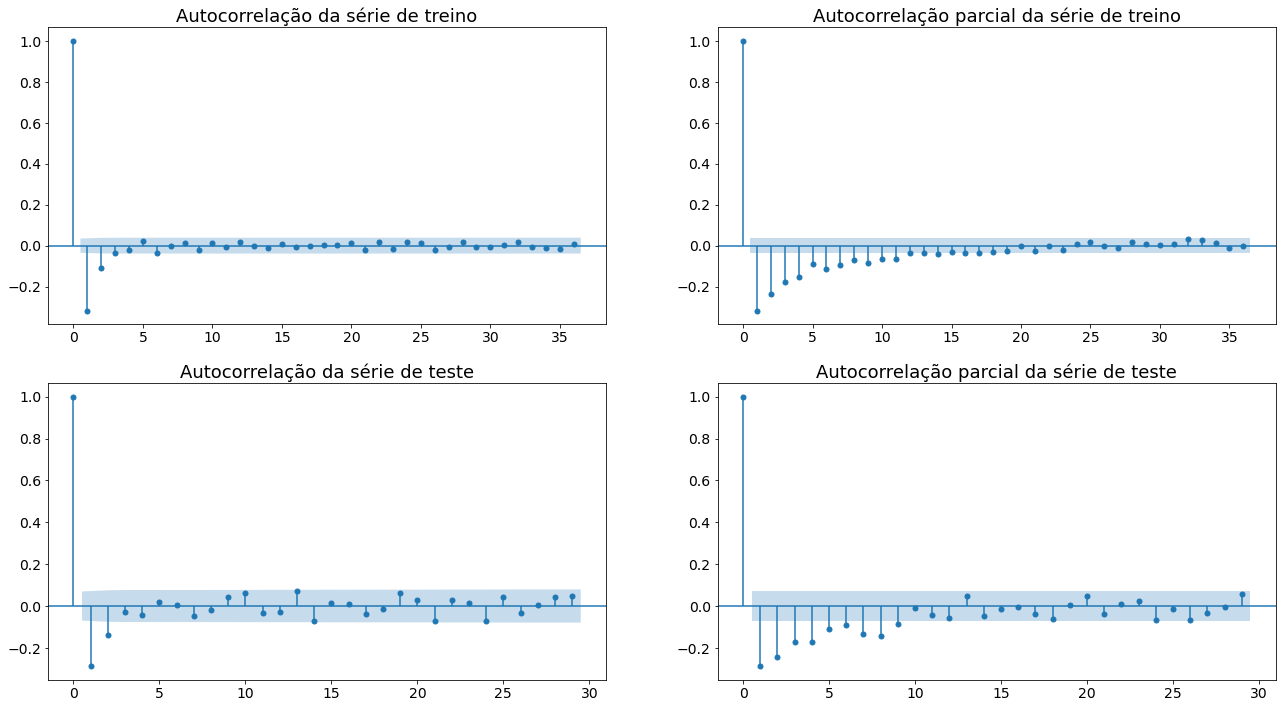

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(22,12))
tsa.plot_acf(treino.diff()[1:], ax = axs[0,0], title="Autocorrelação da série de treino")
tsa.plot_pacf(treino.diff()[1:], ax = axs[0,1], title="Autocorrelação parcial da série de treino")
tsa.plot_acf(teste.diff()[1:], ax = axs[1,0], title="Autocorrelação da série de teste")
_ = tsa.plot_pacf(teste.diff()[1:], ax = axs[1,1], title="Autocorrelação parcial da série de teste")

In [ ]:
holtwinters_aju = sm.tsa.ExponentialSmoothing(treino, initialization_method='estimated', damped_trend=True,
                                       trend="add", seasonal="add", seasonal_periods=365).fit(
                                        optimized=True, method="TNC")

In [ ]:
holtwinters_aju.params_formatted

,name,param,optimized
smoothing_level,alpha,0.314735,True
smoothing_trend,beta,0.000000,True
smoothing_seasonal,gamma,0.000000,True
initial_level,l.0,27.233905,True
initial_trend,b.0,-0.061875,True
...,...,...,...
initial_seasons.360,s.360,0.603687,True
initial_seasons.361,s.361,0.629420,True
initial_seasons.362,s.362,0.565899,True
initial_seasons.363,s.363,0.604656,True


In [ ]:
predicao_hw = holtwinters_aju.predict(start=teste.index[0], end=teste.index[-1])

In [ ]:
[mape(teste, predicao_hw),
metrics.r2_score(teste, predicao_hw),
metrics.mean_absolute_error(teste, predicao_hw),
metrics.median_absolute_error(teste, predicao_hw),
metrics.mean_squared_error(teste, predicao_hw)]

[3.0464209155267192,
 0.3591936809356089,
 0.7835550030781803,
 0.5496164295924864,
 1.105386395176359]

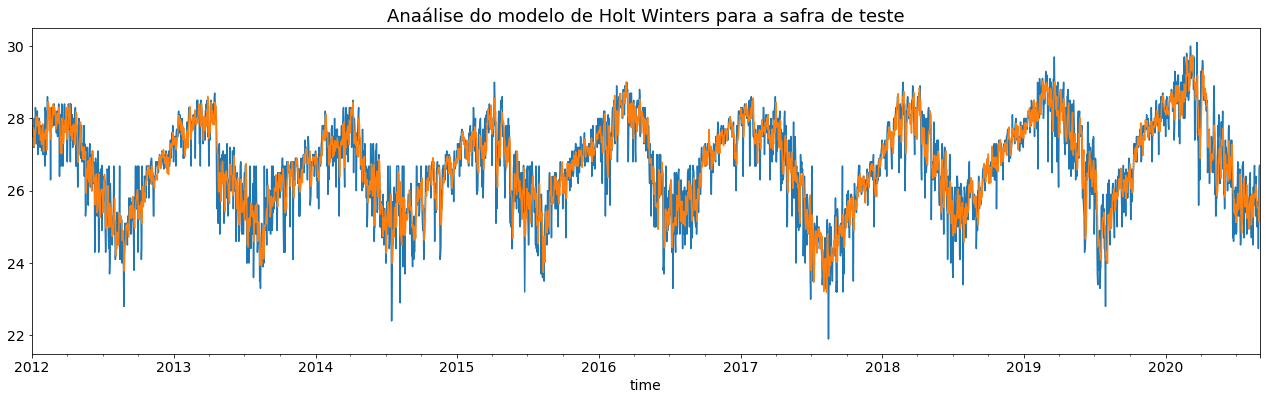

In [ ]:
ax = treino.plot(title="Anaálise do modelo de Holt Winters para a safra de teste")
_ = holtwinters_aju.fittedvalues.plot(ax=ax)

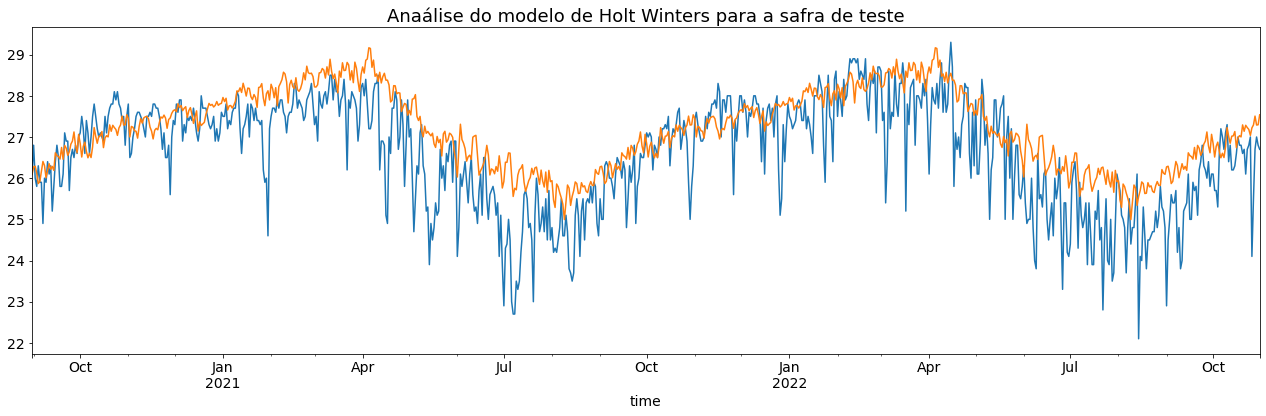

In [ ]:
ax = teste.plot(title="Anaálise do modelo de Holt Winters para a safra de teste")
_ = predicao_hw.plot(ax=ax)

#### SARIMA

In [ ]:
split_intra = int(len(aracaju_intradiario.temp) * 70 / 100) #encontrando o ponto de separação de 70% para treino e 30% para teste
treino_intra, teste_intra = aracaju_intradiario.temp[:split_intra], aracaju_intradiario.temp[split_intra:]

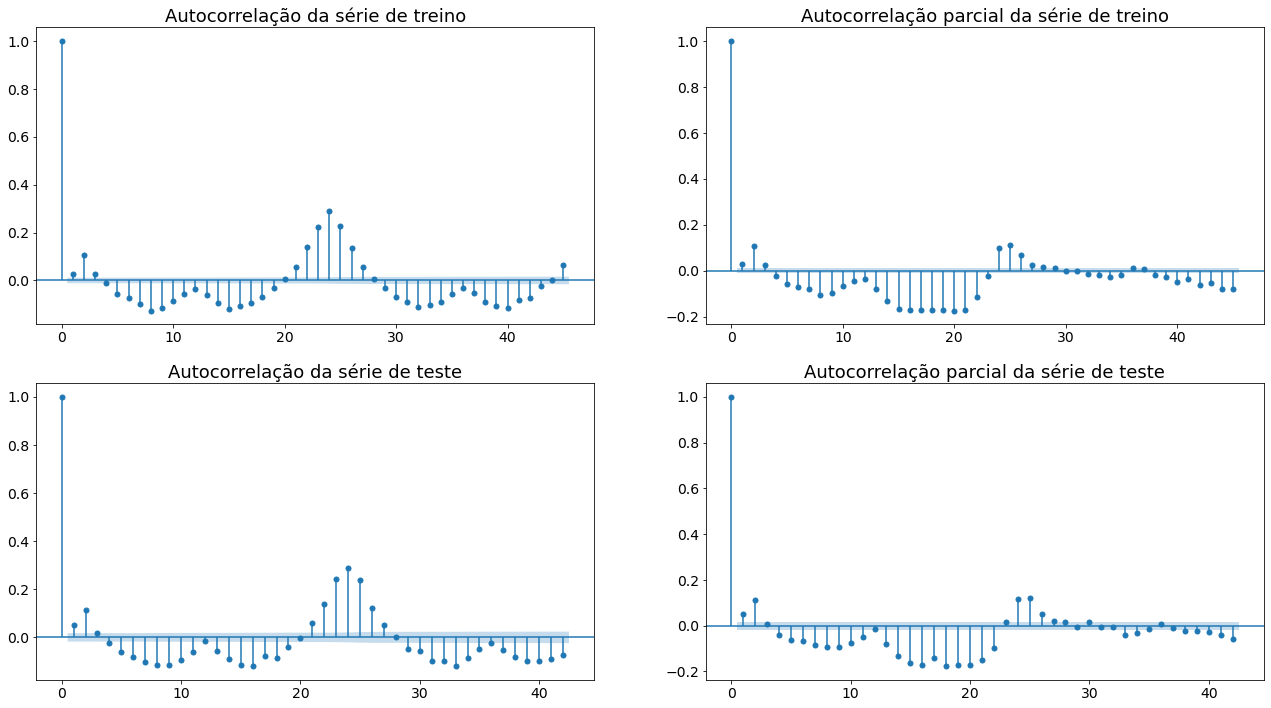

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(22,12))
tsa.plot_acf(treino_intra.diff()[1:], ax = axs[0,0], title="Autocorrelação da série de treino")
tsa.plot_pacf(treino_intra.diff()[1:], ax = axs[0,1], title="Autocorrelação parcial da série de treino")
tsa.plot_acf(teste_intra.diff()[1:], ax = axs[1,0], title="Autocorrelação da série de teste")
_ = tsa.plot_pacf(teste_intra.diff()[1:], ax = axs[1,1], title="Autocorrelação parcial da série de teste")

In [ ]:
modelo_sarima = sm.tsa.SARIMAX(treino_intra[-1095:], order=(2, 1, 2), seasonal_order=(1,0,1,24),
                               freq="H", trend="c").fit(disp=-1)

In [ ]:
predicao_sarima = modelo_sarima.predict(start=teste_intra.index[0], end=teste_intra.index[600])

In [ ]:
[mape(predicao_sarima, teste_intra[teste_intra.index.isin(predicao_sarima.index)]),
metrics.r2_score(predicao_sarima, teste_intra[teste_intra.index.isin(predicao_sarima.index)]),
metrics.mean_absolute_error(predicao_sarima, teste_intra[teste_intra.index.isin(predicao_sarima.index)]),
metrics.median_absolute_error(predicao_sarima, teste_intra[teste_intra.index.isin(predicao_sarima.index)]),
metrics.mean_squared_error(predicao_sarima, teste_intra[teste_intra.index.isin(predicao_sarima.index)])]

[7.3368907604212925,
 -1.6771413390782839,
 1.7909507232930453,
 1.8271151136088477,
 4.063348455536849]

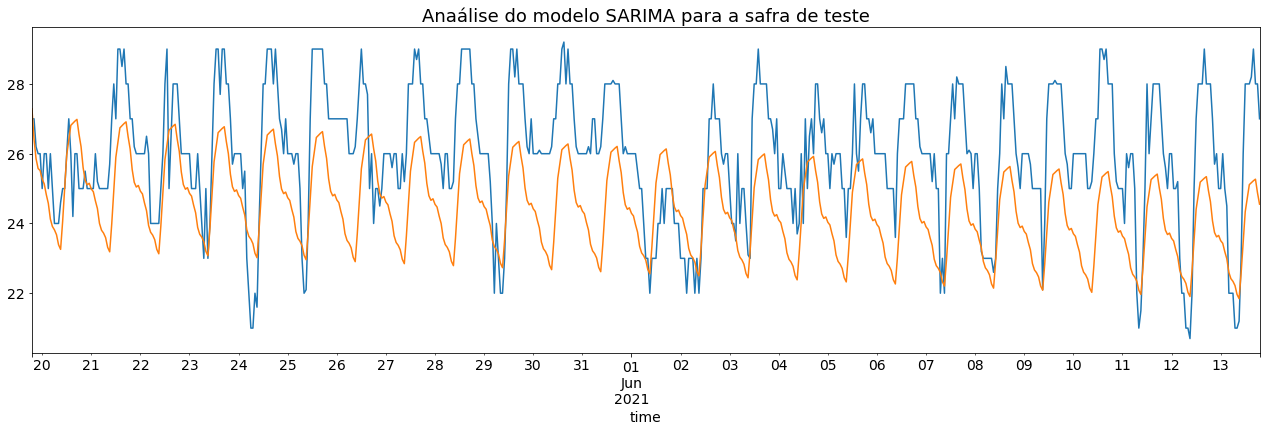

In [ ]:
ax = teste_intra[teste_intra.index.isin(predicao_sarima.index)].plot(title="Anaálise do modelo SARIMA para a safra de teste")
_ = predicao_sarima.plot(ax=ax)

### Predição por Rolagem

In [ ]:
aju_semsazo = serie_aracaju.tavg.diff().diff(365).dropna()
split = int(len(aju_semsazo) * 70 / 100) #encontrando o ponto de separação de 70% para treino e 30% para teste
treino, teste = aju_semsazo[:split], aju_semsazo[split:]

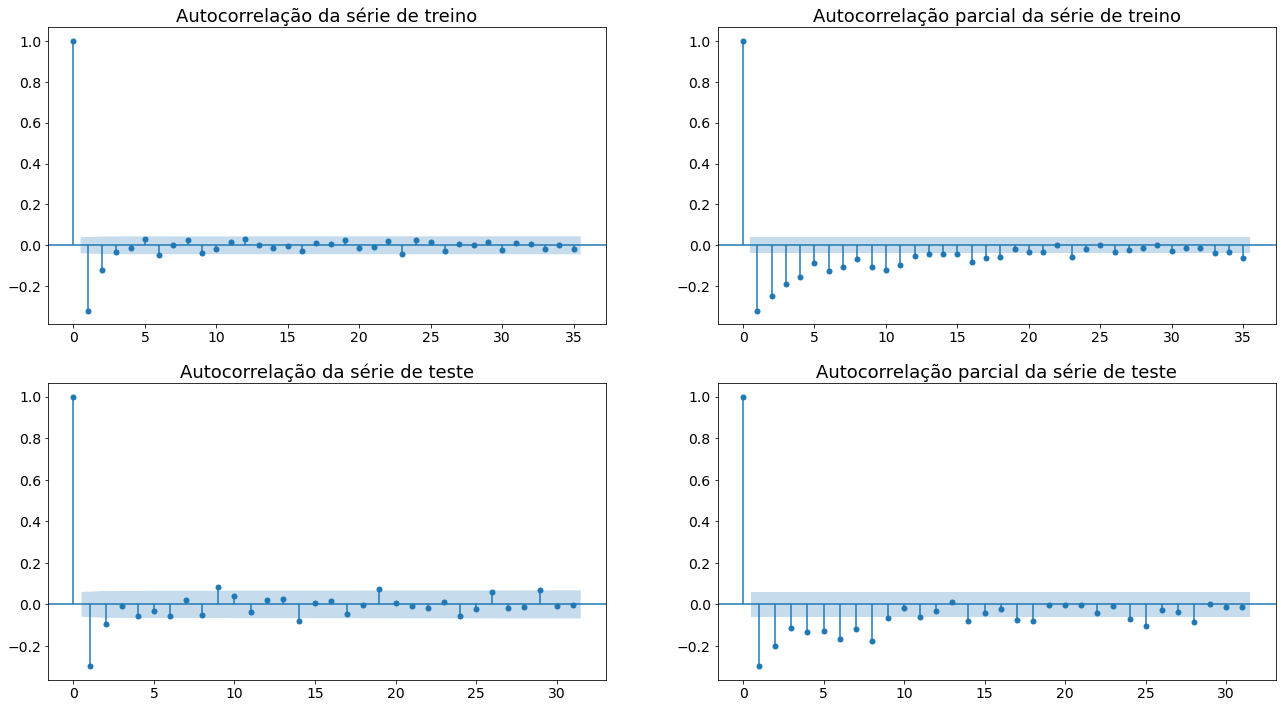

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(22,12))
tsa.plot_acf(treino, ax = axs[0,0], title="Autocorrelação da série de treino")
tsa.plot_pacf(treino, ax = axs[0,1], title="Autocorrelação parcial da série de treino")
tsa.plot_acf(teste, ax = axs[1,0], title="Autocorrelação da série de teste")
_ = tsa.plot_pacf(teste, ax = axs[1,1], title="Autocorrelação parcial da série de teste")

In [ ]:
def predicao_por_rolagem(train, test, order, ts=1):
    history = train.copy()
    model = sm.tsa.arima.ARIMA(history, order= order).fit()
    predictions = []
    results = {}
    yhat = model.forecast()[0]

    predictions.append(yhat)
    history.loc[teste.index[0]] = teste[0]
    for i in tqdm(range(1, len(test))):
        model = sm.tsa.arima.ARIMA(history, order= order).fit()
        yhat = model.forecast(steps=ts)[0]
        predictions.append(yhat)
        history.loc[teste.index[i]] = teste[i]

    return pd.Series(predictions, index=test.index)

In [ ]:
resultado = predicao_por_rolagem(treino[-730:], teste[:365], (5, 0, 2))

  0%|          | 0/364 [00:00<?, ?it/s]

### Validação Cruzada

**Time Series Split**

Como explicado nas primeiras sessões do curso, um dos princípios da análise de séries temporais é a dependência temporal. Sendo assim, não podemos embaralhar os dados.

1. Escolhemos a função de avaliação
2. Usamos a validação cruzada para avaliar o erro do modelos escolhido
3. Analizamos variabilidade do erro nas diferentes amostras;

<center>

![img](https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_013.png)
</center>



Como queremos avaliar a equação que construímos para quaisquer instantes de tempo, é uma boa pratica separarmos um espaço temporal entre a safra de treino e de validação.

<center>

![img](https://miro.medium.com/v2/resize:fit:720/format:webp/1*XZPdh0362RO9UUw1Irpb-w.png)

[fonte: Towards Data Science | Vitor Cerqueira](https://towardsdatascience.com/4-things-to-do-when-applying-cross-validation-with-time-series-c6a5674ebf3a)
</center>

In [ ]:
def timeseriesCVscore(series, loss_function=metrics.mean_squared_error, slen=365, gap=10, ts=200):
    """
        Returns error on CV  

        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []

    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=5, gap=gap, test_size=ts)

    # iterating over folds, train model on each, forecast and calculate error
    for treino, teste in tqdm(tscv.split(series), total=tscv.get_n_splits(), desc="Time Series Split"):

        modelo = sm.tsa.ExponentialSmoothing(
            endog=series[treino],
            trend="add",
            seasonal="add",
            initialization_method='estimated',
            damped_trend=True,
            seasonal_periods=slen
        ).fit(
            optimized=True,
            method="TNC"
        )

        predictions = modelo.predict(start=series[teste].index[0], end=series[teste].index[-1])
        actual = series[teste]
        error = loss_function(predictions, actual)
        errors.append([
              mape(predictions, actual),
              metrics.r2_score(predictions, actual),
              metrics.mean_absolute_error(predictions, actual),
              metrics.median_absolute_error(predictions, actual),
              metrics.mean_squared_error(predictions, actual),
              metrics.mean_squared_log_error(predictions, actual),
              modelo.params['smoothing_level'],
              modelo.params['smoothing_trend'],
              modelo.params['smoothing_seasonal']
            ])

    return errors

In [ ]:
resultado = timeseriesCVscore(serie_aracaju.tavg, mape)
resultado_df = pd.DataFrame(resultado)
resultado_df.columns = ["MAPE","R Quadrado","MAE","MedAE","MSE","MSLE","Level","Trend","Sazonal"]
resultado_df

Time Series Split:   0%|          | 0/5 [00:00<?, ?it/s]

,MAPE,R Quadrado,MAE,MedAE,MSE,MSLE,Level,Trend,Sazonal
0,2.792196,0.148707,0.770405,0.645592,0.960623,0.001239,0.299520,0.0,0.0
1,1.764705,0.261759,0.481761,0.419796,0.402426,0.000516,0.316105,0.0,0.0
2,2.817022,-0.019119,0.740205,0.606739,0.965469,0.001385,0.322955,0.0,0.0
3,2.011928,-0.552128,0.557060,0.447957,0.573061,0.000721,0.342495,0.0,0.0
4,2.779504,-0.802912,0.712801,0.577716,0.824999,0.001166,0.333700,0.0,0.0


In [ ]:
split = int(len(serie_aracaju.tavg) * 70 / 100) #encontrando o ponto de separação de 70% para treino e 30% para teste
treino, teste = serie_aracaju.tavg[:split], serie_aracaju.tavg[split:]

In [ ]:
holtwinters_aju = sm.tsa.ExponentialSmoothing(
            endog = treino,
            trend="add",
            seasonal="add",
            damped_trend=True,
            seasonal_periods=365,
            initialization_method='estimated'
        ).fit(
            optimized=True,
            method="TNC"
        )

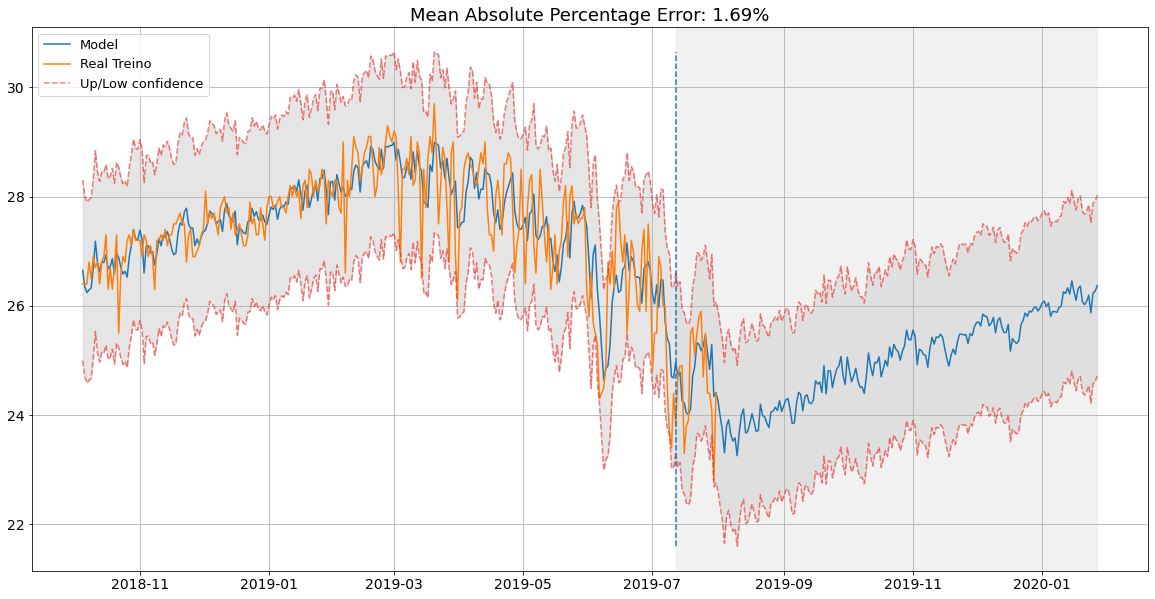

In [ ]:
visualizaModelo(treino[treino.index >= treino.index[-300]], holtwinters_aju, n_steps=180, plot_intervals=True)

### Validando distintos horizontes de previsão

In [ ]:
len(treino),len(teste)

(2769, 1188)

In [ ]:
erros_janelados = []
for h in [30,60,90,120,180]:
  predictions = holtwinters_aju.predict(
                  start=teste.index[0],
                  end=(teste.index[0] + timedelta(days=h))
                )
  actual = teste
  erro = [
            mape(predictions, teste[:h]),
            metrics.r2_score(predictions, teste[:h+1]),
            metrics.mean_absolute_error(predictions, teste[:h+1]),
            metrics.median_absolute_error(predictions, teste[:h+1]),
            metrics.mean_squared_error(predictions, teste[:h+1]),
            metrics.mean_squared_log_error(predictions, teste[:h+1]),
          ]
  erros_janelados.append(erro)

In [ ]:
avaliacao_janelas = pd.DataFrame(erros_janelados)
avaliacao_janelas.columns = ["MAPE","r_quadrado","MAE","MedAE","MSE","MSLE"]
avaliacao_janelas

,MAPE,r_quadrado,MAE,MedAE,MSE,MSLE
0,6.948382,-51.202449,1.677222,1.859005,3.231322,0.004845
1,7.036284,-18.922664,1.698199,1.827441,3.236318,0.004760
2,7.371381,-12.011092,1.794731,1.888247,3.550439,0.005080
3,7.841512,-10.505841,1.937752,2.033144,4.095851,0.005711
4,8.265817,-6.555529,2.077962,2.194136,4.640300,0.006230


## Exercício

1. Ajuste um modelo de Suavização Exponencial para a série de temperatura e:
  1. Compare visualmente a série de treino com a previsão do modelo para a mesma safra
  2. Compare visualmente a série de teste com a previsão do modelo para mesma safra
  3. Para cada uma das safras, calcule as métricas de avaliação de MAPE, R Quadrado, MAE, MedAE, MSE e MSLE.
2. Estime a sazonalidade e tendência da série de temperatura da sua cidade, as subtraia da série original e ajuste um modelo ARMA para a série resultante. (separe o ano de 2022 como safra de teste.)
3. Para este mesmo modelo ajustado, realize uma previsão da safra de teste e acrescente os sinais de tendência e sazonalidade anteriormente extraídos.

## Referências
- https://towardsdatascience.com/4-things-to-do-when-applying-cross-validation-with-time-series-c6a5674ebf3a
- https://machinelearningmastery.com/probabilistic-model-selection-measures/
- https://machinelearningmastery.com/probabilistic-model-selection-measures/
- https://mlcourse.ai/book/topic09/topic9_part1_time_series_python.html#triple-exponential-smoothing-a-k-a-holt-winters
- https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html
- https://towardsdatascience.com/generating-confidence-intervals-for-regression-models-2dd60026fbce
